In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import optuna
import numpy as np
import matplotlib.pyplot as plt
import dataProcess

from datetime import datetime

In [2]:
hourly = '.\\Raw data\\ten_year\\weatherstats_toronto_hourly.csv'
daily = '.\\Raw data\\ten_year\\weatherstats_toronto_daily.csv'
start = datetime(2014, 4, 16).date()
end = datetime(2024, 4, 10).date()
data = dataProcess.generateDataNoLoader(hourly, daily, start, end)
train_data = data['train']
val_data = data['validation']
test_data = data['test']

In [3]:
class FlatWeatherMLP(nn.Module):
    def __init__(self, input_size=312, hidden_size=500):
        super(FlatWeatherMLP, self).__init__()
        self.inputLayer = nn.Linear(input_size, hidden_size)
        self.hiddenLayer = nn.Linear(hidden_size, hidden_size)
        self.outputLayer = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.to(torch.float32)
        x = torch.flatten(x, start_dim=1)
        # print(x.shape)
        x = self.inputLayer(x)
        x = self.relu(x)
        # print(f'fc1: {x}')
        x = self.hiddenLayer(x)
        x = self.relu(x)
        # print(f'fc2: {x}')
        x = self.outputLayer(x)
        # print(f'fc3: {x}')
        # print(x)
        x = torch.squeeze(x)
        return x

In [4]:
# for d, target in data['train']:
#     print(d.dtype)
#     print(target.shape)
def accuracy(model, data):
    totalDiff = 0.0
    count = 0
    loader = DataLoader(data, batch_size=100)
    for data, target in loader:
        count = count + 1
        z = model(data)
        # print(z)
        totalDiff += torch.sum(torch.abs(target - z))

    print(target, z)
    return(totalDiff / count)

# accuracy(FlatWeatherMLP(), data['train'])
        


In [22]:

def train_model(model, trainData, valData, lr=.002, batchSize=10, epochs=100, v=True, plot=False):
    loader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
    vloader = DataLoader(valData, batch_size=batchSize, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for epoch in range(epochs):
        totalLoss = 0
        c = 0
        for d, t in loader:
            t = torch.squeeze(t)
            c += 1
            optimizer.zero_grad()
            z = model(d)
            z = torch.squeeze(z)
            loss = criterion(z, t)
            loss.backward()
            optimizer.step()
            totalLoss += loss.item()
        train_loss.append(np.log(totalLoss))
        train_acc.append(accuracy(model, train_data).item())
        if v:
            print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {totalLoss / len(loader)}')
        model.eval()
        totalLossVal = 0
        with torch.no_grad():
            for d, t in vloader:
                z = model(d)
                loss = criterion(z, t)
                totalLossVal += loss.item()
        val_acc.append(accuracy(model, val_data).item())
        val_loss.append(np.log(totalLossVal))
        if v:
            print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {totalLossVal / len(loader)}')
    if plot:
        plt.figure()
        plt.plot(range(epochs), train_loss)
        plt.plot(range(epochs), val_loss)
        plt.title("MSELoss Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss (log scale)")
        plt.legend(['Train', "Validation"])

        plt.figure()
        plt.plot(range(epochs), train_acc)
        plt.plot(range(epochs), val_acc)
        plt.title("Average Temperature Prediction Inaccuracies")
        plt.xlabel("Epochs")
        plt.ylabel("Average Temperature Inaccuracy (Celcius)")
        plt.legend(['Train', "Validation"])

    print(accuracy(model, data['validation']))
# model = FlatWeatherMLP()
# train_model(model, train_data, val_data)
# accuracy(model, data['validation'])

Epoch [1/50], Training Loss: 206621.48416139453
Epoch [1/50], Validation Loss: 58.75657249485842


c:\Users\Blake\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/50], Training Loss: 181.87400362129037
Epoch [2/50], Validation Loss: 121.12791755781745
Epoch [3/50], Training Loss: 116.25881051797471
Epoch [3/50], Validation Loss: 39.152386341226816
Epoch [4/50], Training Loss: 86.7115776220225
Epoch [4/50], Validation Loss: 50.13700468529205
Epoch [5/50], Training Loss: 85.39751760421261
Epoch [5/50], Validation Loss: 29.109757304740942
Epoch [6/50], Training Loss: 78.77022468988797
Epoch [6/50], Validation Loss: 31.09912934720791
Epoch [7/50], Training Loss: 77.70994340659287
Epoch [7/50], Validation Loss: 34.96623302055394
Epoch [8/50], Training Loss: 66.77502550397601
Epoch [8/50], Validation Loss: 36.017357792173115
Epoch [9/50], Training Loss: 50.96859784939322
Epoch [9/50], Validation Loss: 27.321239042941325
Epoch [10/50], Training Loss: 47.28140971627653
Epoch [10/50], Validation Loss: 40.21550493416149
Epoch [11/50], Training Loss: 45.77997938498923
Epoch [11/50], Validation Loss: 58.08850899270053
Epoch [12/50], Training Loss: 

tensor(468.1586, grad_fn=<DivBackward0>)

In [ ]:
def objective(trial):
    lr = trial.suggest_float('lr', .001, .05)
    batchSize = trial.suggest_int('batchSize', 1, 50)
    epochs = trial.suggest_int('epochs', 5, 100)
    hidden_size = trial.suggest_int('hidden_size', 10, 312)
    model = FlatWeatherMLP(hidden_size=hidden_size)
    train_model(model, train_data, val_data, lr=lr, batchSize=batchSize, epochs=epochs, v=False)
    return accuracy(model, data['validation'])

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-04-17 15:24:12,182] A new study created in memory with name: no-name-604c2f91-8ea0-4ada-a32d-6a1bdfbc3d49
[I 2024-04-17 15:24:25,552] Trial 0 finished with value: 84.33026885986328 and parameters: {'lr': 0.027083513940992676, 'batchSize': 30, 'epochs': 35, 'hidden_size': 247}. Best is trial 0 with value: 84.33026885986328.


tensor(84.3303, grad_fn=<DivBackward0>)


[I 2024-04-17 15:24:54,723] Trial 1 finished with value: 3.6715922355651855 and parameters: {'lr': 0.008155626482340653, 'batchSize': 31, 'epochs': 78, 'hidden_size': 218}. Best is trial 1 with value: 3.6715922355651855.


tensor(3.6716, grad_fn=<DivBackward0>)


[I 2024-04-17 15:25:16,151] Trial 2 finished with value: 9.835444450378418 and parameters: {'lr': 0.01470019564482726, 'batchSize': 11, 'epochs': 81, 'hidden_size': 37}. Best is trial 1 with value: 3.6715922355651855.


tensor(9.8354, grad_fn=<DivBackward0>)


[I 2024-04-17 15:25:22,963] Trial 3 finished with value: 5.783455848693848 and parameters: {'lr': 0.0074713598620917325, 'batchSize': 24, 'epochs': 46, 'hidden_size': 28}. Best is trial 1 with value: 3.6715922355651855.


tensor(5.7835, grad_fn=<DivBackward0>)


[I 2024-04-17 15:25:28,034] Trial 4 finished with value: 9.27778434753418 and parameters: {'lr': 0.0182683531425205, 'batchSize': 35, 'epochs': 55, 'hidden_size': 16}. Best is trial 1 with value: 3.6715922355651855.


tensor(9.2778, grad_fn=<DivBackward0>)


[I 2024-04-17 15:26:13,329] Trial 5 finished with value: 3.8373594284057617 and parameters: {'lr': 0.03455111715457398, 'batchSize': 16, 'epochs': 70, 'hidden_size': 187}. Best is trial 1 with value: 3.6715922355651855.


tensor(3.8374, grad_fn=<DivBackward0>)


[I 2024-04-17 15:26:35,899] Trial 6 finished with value: 13.258589744567871 and parameters: {'lr': 0.03119967654995494, 'batchSize': 17, 'epochs': 34, 'hidden_size': 222}. Best is trial 1 with value: 3.6715922355651855.


tensor(13.2586, grad_fn=<DivBackward0>)


[I 2024-04-17 15:27:07,552] Trial 7 finished with value: 2.713200092315674 and parameters: {'lr': 0.0030861702410551915, 'batchSize': 19, 'epochs': 84, 'hidden_size': 118}. Best is trial 7 with value: 2.713200092315674.


tensor(2.7132, grad_fn=<DivBackward0>)


[I 2024-04-17 15:27:20,567] Trial 8 finished with value: 128.52830505371094 and parameters: {'lr': 0.02509176380179215, 'batchSize': 27, 'epochs': 32, 'hidden_size': 231}. Best is trial 7 with value: 2.713200092315674.


tensor(128.5283, grad_fn=<DivBackward0>)


[I 2024-04-17 15:27:32,326] Trial 9 finished with value: 9.277052879333496 and parameters: {'lr': 0.025487927522022114, 'batchSize': 28, 'epochs': 43, 'hidden_size': 133}. Best is trial 7 with value: 2.713200092315674.


tensor(9.2771, grad_fn=<DivBackward0>)


[I 2024-04-17 15:27:48,236] Trial 10 finished with value: 9.613781929016113 and parameters: {'lr': 0.04881442202554903, 'batchSize': 45, 'epochs': 98, 'hidden_size': 111}. Best is trial 7 with value: 2.713200092315674.


tensor(9.6138, grad_fn=<DivBackward0>)


[I 2024-04-17 15:54:38,312] Trial 11 finished with value: 11.691160202026367 and parameters: {'lr': 0.0013004794362196058, 'batchSize': 2, 'epochs': 99, 'hidden_size': 289}. Best is trial 7 with value: 2.713200092315674.


tensor(11.6912, grad_fn=<DivBackward0>)


[I 2024-04-17 15:54:40,007] Trial 12 finished with value: 11.305587768554688 and parameters: {'lr': 0.0010362252091796849, 'batchSize': 41, 'epochs': 5, 'hidden_size': 96}. Best is trial 7 with value: 2.713200092315674.


tensor(11.3056, grad_fn=<DivBackward0>)


[I 2024-04-17 15:55:54,371] Trial 13 finished with value: 4.579885482788086 and parameters: {'lr': 0.011125462014290034, 'batchSize': 38, 'epochs': 78, 'hidden_size': 178}. Best is trial 7 with value: 2.713200092315674.


tensor(4.5799, grad_fn=<DivBackward0>)


[I 2024-04-17 15:56:22,653] Trial 14 finished with value: 3.1579630374908447 and parameters: {'lr': 0.006994288449771821, 'batchSize': 50, 'epochs': 65, 'hidden_size': 73}. Best is trial 7 with value: 2.713200092315674.


tensor(3.1580, grad_fn=<DivBackward0>)


[I 2024-04-17 15:56:48,303] Trial 15 finished with value: 3.6920812129974365 and parameters: {'lr': 0.017144504456922817, 'batchSize': 50, 'epochs': 61, 'hidden_size': 64}. Best is trial 7 with value: 2.713200092315674.


tensor(3.6921, grad_fn=<DivBackward0>)


[I 2024-04-17 15:57:34,576] Trial 16 finished with value: 3.1984357833862305 and parameters: {'lr': 0.0050592346117196, 'batchSize': 19, 'epochs': 85, 'hidden_size': 73}. Best is trial 7 with value: 2.713200092315674.


tensor(3.1984, grad_fn=<DivBackward0>)


[I 2024-04-17 15:58:37,022] Trial 17 finished with value: 9.404226303100586 and parameters: {'lr': 0.04105569784069932, 'batchSize': 9, 'epochs': 65, 'hidden_size': 147}. Best is trial 7 with value: 2.713200092315674.


tensor(9.4042, grad_fn=<DivBackward0>)


[I 2024-04-17 15:58:52,849] Trial 18 finished with value: 4.330657005310059 and parameters: {'lr': 0.012548508350284489, 'batchSize': 47, 'epochs': 91, 'hidden_size': 111}. Best is trial 7 with value: 2.713200092315674.


tensor(4.3307, grad_fn=<DivBackward0>)


[I 2024-04-17 16:00:58,402] Trial 19 finished with value: 9.280421257019043 and parameters: {'lr': 0.02099680417470713, 'batchSize': 3, 'epochs': 71, 'hidden_size': 58}. Best is trial 7 with value: 2.713200092315674.


tensor(9.2804, grad_fn=<DivBackward0>)


[I 2024-04-17 16:00:59,374] Trial 20 finished with value: 5.592511177062988 and parameters: {'lr': 0.005146139826808446, 'batchSize': 21, 'epochs': 5, 'hidden_size': 95}. Best is trial 7 with value: 2.713200092315674.


tensor(5.5925, grad_fn=<DivBackward0>)


[I 2024-04-17 16:01:22,455] Trial 21 finished with value: 3.3272476196289062 and parameters: {'lr': 0.005874537681157765, 'batchSize': 20, 'epochs': 87, 'hidden_size': 67}. Best is trial 7 with value: 2.713200092315674.


tensor(3.3272, grad_fn=<DivBackward0>)


[I 2024-04-17 16:01:53,041] Trial 22 finished with value: 9.452885627746582 and parameters: {'lr': 0.009789632715461497, 'batchSize': 17, 'epochs': 86, 'hidden_size': 81}. Best is trial 7 with value: 2.713200092315674.


tensor(9.4529, grad_fn=<DivBackward0>)


[I 2024-04-17 16:02:35,707] Trial 23 finished with value: 2.931628465652466 and parameters: {'lr': 0.0034330419633461, 'batchSize': 13, 'epochs': 71, 'hidden_size': 131}. Best is trial 7 with value: 2.713200092315674.


tensor(2.9316, grad_fn=<DivBackward0>)


[I 2024-04-17 16:03:14,890] Trial 24 finished with value: 4.155984878540039 and parameters: {'lr': 0.003194101047673106, 'batchSize': 11, 'epochs': 57, 'hidden_size': 132}. Best is trial 7 with value: 2.713200092315674.


tensor(4.1560, grad_fn=<DivBackward0>)


[I 2024-04-17 16:06:41,446] Trial 25 finished with value: 9.332955360412598 and parameters: {'lr': 0.013855207055402496, 'batchSize': 6, 'epochs': 70, 'hidden_size': 175}. Best is trial 7 with value: 2.713200092315674.


tensor(9.3330, grad_fn=<DivBackward0>)


[I 2024-04-17 16:07:54,379] Trial 26 finished with value: 3.630436420440674 and parameters: {'lr': 0.009305079555247876, 'batchSize': 13, 'epochs': 47, 'hidden_size': 156}. Best is trial 7 with value: 2.713200092315674.


tensor(3.6304, grad_fn=<DivBackward0>)


[I 2024-04-17 16:08:40,970] Trial 27 finished with value: 9.506515502929688 and parameters: {'lr': 0.019011412458846563, 'batchSize': 23, 'epochs': 74, 'hidden_size': 115}. Best is trial 7 with value: 2.713200092315674.


tensor(9.5065, grad_fn=<DivBackward0>)


[I 2024-04-17 16:08:48,906] Trial 28 finished with value: 3.134721517562866 and parameters: {'lr': 0.004072584142846552, 'batchSize': 34, 'epochs': 64, 'hidden_size': 45}. Best is trial 7 with value: 2.713200092315674.


tensor(3.1347, grad_fn=<DivBackward0>)


[I 2024-04-17 16:09:19,294] Trial 29 finished with value: 12.626982688903809 and parameters: {'lr': 0.022890515718144204, 'batchSize': 33, 'epochs': 92, 'hidden_size': 196}. Best is trial 7 with value: 2.713200092315674.


tensor(12.6270, grad_fn=<DivBackward0>)


[I 2024-04-17 16:09:27,532] Trial 30 finished with value: 6.065945148468018 and parameters: {'lr': 0.003466869713669652, 'batchSize': 37, 'epochs': 26, 'hidden_size': 301}. Best is trial 7 with value: 2.713200092315674.


tensor(6.0659, grad_fn=<DivBackward0>)


[I 2024-04-17 16:09:49,524] Trial 31 finished with value: 3.214221715927124 and parameters: {'lr': 0.006651362696541523, 'batchSize': 14, 'epochs': 64, 'hidden_size': 55}. Best is trial 7 with value: 2.713200092315674.


tensor(3.2142, grad_fn=<DivBackward0>)


[I 2024-04-17 16:09:55,562] Trial 32 finished with value: 3.7772719860076904 and parameters: {'lr': 0.009247767712961208, 'batchSize': 43, 'epochs': 60, 'hidden_size': 45}. Best is trial 7 with value: 2.713200092315674.


tensor(3.7773, grad_fn=<DivBackward0>)


[I 2024-04-17 16:10:08,280] Trial 33 finished with value: 5.764491558074951 and parameters: {'lr': 0.0013151001669781256, 'batchSize': 31, 'epochs': 79, 'hidden_size': 85}. Best is trial 7 with value: 2.713200092315674.


tensor(5.7645, grad_fn=<DivBackward0>)


[I 2024-04-17 16:10:32,930] Trial 34 finished with value: 11.884943962097168 and parameters: {'lr': 0.015330585693756026, 'batchSize': 7, 'epochs': 49, 'hidden_size': 17}. Best is trial 7 with value: 2.713200092315674.


tensor(11.8849, grad_fn=<DivBackward0>)


[I 2024-04-17 16:10:45,333] Trial 35 finished with value: 4.0655436515808105 and parameters: {'lr': 0.007777145458434966, 'batchSize': 50, 'epochs': 67, 'hidden_size': 40}. Best is trial 7 with value: 2.713200092315674.


tensor(4.0655, grad_fn=<DivBackward0>)


[I 2024-04-17 16:11:21,887] Trial 36 finished with value: 3.778512954711914 and parameters: {'lr': 0.011524207655667026, 'batchSize': 25, 'epochs': 52, 'hidden_size': 132}. Best is trial 7 with value: 2.713200092315674.


tensor(3.7785, grad_fn=<DivBackward0>)


[I 2024-04-17 16:11:59,912] Trial 37 finished with value: 2.7833948135375977 and parameters: {'lr': 0.0034158697423379543, 'batchSize': 29, 'epochs': 82, 'hidden_size': 100}. Best is trial 7 with value: 2.713200092315674.


tensor(2.7834, grad_fn=<DivBackward0>)


[I 2024-04-17 16:12:47,194] Trial 38 finished with value: 4.558320045471191 and parameters: {'lr': 0.0035555542256643655, 'batchSize': 29, 'epochs': 76, 'hidden_size': 149}. Best is trial 7 with value: 2.713200092315674.


tensor(4.5583, grad_fn=<DivBackward0>)


[I 2024-04-17 16:13:29,410] Trial 39 finished with value: 3.7216475009918213 and parameters: {'lr': 0.030210416600908837, 'batchSize': 34, 'epochs': 82, 'hidden_size': 100}. Best is trial 7 with value: 2.713200092315674.


tensor(3.7216, grad_fn=<DivBackward0>)


[I 2024-04-17 16:14:42,366] Trial 40 finished with value: 9.280424118041992 and parameters: {'lr': 0.039223341917939, 'batchSize': 23, 'epochs': 92, 'hidden_size': 122}. Best is trial 7 with value: 2.713200092315674.


tensor(9.2804, grad_fn=<DivBackward0>)


[I 2024-04-17 16:15:00,178] Trial 41 finished with value: 2.993248462677002 and parameters: {'lr': 0.007086934136281764, 'batchSize': 26, 'epochs': 75, 'hidden_size': 25}. Best is trial 7 with value: 2.713200092315674.


tensor(2.9932, grad_fn=<DivBackward0>)


[I 2024-04-17 16:15:14,323] Trial 42 finished with value: 3.215573787689209 and parameters: {'lr': 0.0037834779666875316, 'batchSize': 26, 'epochs': 75, 'hidden_size': 12}. Best is trial 7 with value: 2.713200092315674.


tensor(3.2156, grad_fn=<DivBackward0>)


[I 2024-04-17 16:15:34,869] Trial 43 finished with value: 3.0922932624816895 and parameters: {'lr': 0.00793643149297237, 'batchSize': 28, 'epochs': 83, 'hidden_size': 24}. Best is trial 7 with value: 2.713200092315674.


tensor(3.0923, grad_fn=<DivBackward0>)


[I 2024-04-17 16:15:58,298] Trial 44 finished with value: 11.057389259338379 and parameters: {'lr': 0.007873403222212475, 'batchSize': 31, 'epochs': 96, 'hidden_size': 30}. Best is trial 7 with value: 2.713200092315674.


tensor(11.0574, grad_fn=<DivBackward0>)


[I 2024-04-17 16:16:30,291] Trial 45 finished with value: 3.4098944664001465 and parameters: {'lr': 0.013748384827700124, 'batchSize': 27, 'epochs': 81, 'hidden_size': 197}. Best is trial 7 with value: 2.713200092315674.


tensor(3.4099, grad_fn=<DivBackward0>)


[I 2024-04-17 16:17:23,565] Trial 46 finished with value: 9.29869556427002 and parameters: {'lr': 0.010471840374796204, 'batchSize': 22, 'epochs': 83, 'hidden_size': 252}. Best is trial 7 with value: 2.713200092315674.


tensor(9.2987, grad_fn=<DivBackward0>)


[I 2024-04-17 16:18:52,621] Trial 47 finished with value: 3.3219964504241943 and parameters: {'lr': 0.0012731461689816127, 'batchSize': 15, 'epochs': 88, 'hidden_size': 167}. Best is trial 7 with value: 2.713200092315674.


tensor(3.3220, grad_fn=<DivBackward0>)


[I 2024-04-17 16:19:19,246] Trial 48 finished with value: 9.277395248413086 and parameters: {'lr': 0.016251293972449312, 'batchSize': 18, 'epochs': 71, 'hidden_size': 25}. Best is trial 7 with value: 2.713200092315674.


tensor(9.2774, grad_fn=<DivBackward0>)


[I 2024-04-17 16:20:19,985] Trial 49 finished with value: 3.6731584072113037 and parameters: {'lr': 0.0062525574115988814, 'batchSize': 24, 'epochs': 95, 'hidden_size': 102}. Best is trial 7 with value: 2.713200092315674.


tensor(3.6732, grad_fn=<DivBackward0>)


[I 2024-04-17 16:20:45,653] Trial 50 finished with value: 9.222328186035156 and parameters: {'lr': 0.01198022565596204, 'batchSize': 28, 'epochs': 42, 'hidden_size': 141}. Best is trial 7 with value: 2.713200092315674.


tensor(9.2223, grad_fn=<DivBackward0>)


[I 2024-04-17 16:21:04,278] Trial 51 finished with value: 2.851456880569458 and parameters: {'lr': 0.0031806603622765396, 'batchSize': 36, 'epochs': 78, 'hidden_size': 47}. Best is trial 7 with value: 2.713200092315674.


tensor(2.8515, grad_fn=<DivBackward0>)


[I 2024-04-17 16:21:17,593] Trial 52 finished with value: 3.5206923484802246 and parameters: {'lr': 0.0017612323714111826, 'batchSize': 37, 'epochs': 78, 'hidden_size': 31}. Best is trial 7 with value: 2.713200092315674.


tensor(3.5207, grad_fn=<DivBackward0>)


[I 2024-04-17 16:21:28,478] Trial 53 finished with value: 9.274776458740234 and parameters: {'lr': 0.007878217725590608, 'batchSize': 40, 'epochs': 100, 'hidden_size': 10}. Best is trial 7 with value: 2.713200092315674.


tensor(9.2748, grad_fn=<DivBackward0>)


[I 2024-04-17 16:21:51,722] Trial 54 finished with value: 2.819718599319458 and parameters: {'lr': 0.005485409506639174, 'batchSize': 32, 'epochs': 74, 'hidden_size': 57}. Best is trial 7 with value: 2.713200092315674.


tensor(2.8197, grad_fn=<DivBackward0>)


[I 2024-04-17 16:22:15,356] Trial 55 finished with value: 5.358395576477051 and parameters: {'lr': 0.00558304534399897, 'batchSize': 30, 'epochs': 73, 'hidden_size': 57}. Best is trial 7 with value: 2.713200092315674.


tensor(5.3584, grad_fn=<DivBackward0>)


[I 2024-04-17 16:22:40,816] Trial 56 finished with value: 5.696153163909912 and parameters: {'lr': 0.0033213466295516423, 'batchSize': 32, 'epochs': 69, 'hidden_size': 82}. Best is trial 7 with value: 2.713200092315674.


tensor(5.6962, grad_fn=<DivBackward0>)


[I 2024-04-17 16:23:11,636] Trial 57 finished with value: 3.436483383178711 and parameters: {'lr': 0.005337258558068654, 'batchSize': 36, 'epochs': 89, 'hidden_size': 90}. Best is trial 7 with value: 2.713200092315674.


tensor(3.4365, grad_fn=<DivBackward0>)


[I 2024-04-17 16:23:31,588] Trial 58 finished with value: 3.445861339569092 and parameters: {'lr': 0.0022828556303530973, 'batchSize': 40, 'epochs': 77, 'hidden_size': 76}. Best is trial 7 with value: 2.713200092315674.


tensor(3.4459, grad_fn=<DivBackward0>)


[I 2024-04-17 16:23:45,264] Trial 59 finished with value: 3.4605417251586914 and parameters: {'lr': 0.009469408344565403, 'batchSize': 11, 'epochs': 12, 'hidden_size': 121}. Best is trial 7 with value: 2.713200092315674.


tensor(3.4605, grad_fn=<DivBackward0>)


[I 2024-04-17 16:24:21,460] Trial 60 finished with value: 9.483138084411621 and parameters: {'lr': 0.04730943488065234, 'batchSize': 18, 'epochs': 58, 'hidden_size': 62}. Best is trial 7 with value: 2.713200092315674.


tensor(9.4831, grad_fn=<DivBackward0>)


[I 2024-04-17 16:24:47,875] Trial 61 finished with value: 2.569736957550049 and parameters: {'lr': 0.004799821565505988, 'batchSize': 26, 'epochs': 84, 'hidden_size': 45}. Best is trial 61 with value: 2.569736957550049.


tensor(2.5697, grad_fn=<DivBackward0>)


[I 2024-04-17 16:25:27,534] Trial 62 finished with value: 3.567263603210449 and parameters: {'lr': 0.004405110452952899, 'batchSize': 20, 'epochs': 85, 'hidden_size': 50}. Best is trial 61 with value: 2.569736957550049.


tensor(3.5673, grad_fn=<DivBackward0>)


[I 2024-04-17 16:25:57,417] Trial 63 finished with value: 4.32840633392334 and parameters: {'lr': 0.006104394130088741, 'batchSize': 26, 'epochs': 81, 'hidden_size': 69}. Best is trial 61 with value: 2.569736957550049.


tensor(4.3284, grad_fn=<DivBackward0>)


[I 2024-04-17 16:26:12,983] Trial 64 finished with value: 3.147916316986084 and parameters: {'lr': 0.0027107919340217043, 'batchSize': 33, 'epochs': 73, 'hidden_size': 35}. Best is trial 61 with value: 2.569736957550049.


tensor(3.1479, grad_fn=<DivBackward0>)


[I 2024-04-17 16:26:40,528] Trial 65 finished with value: 2.9103448390960693 and parameters: {'lr': 0.00499401035414168, 'batchSize': 29, 'epochs': 79, 'hidden_size': 106}. Best is trial 61 with value: 2.569736957550049.


tensor(2.9103, grad_fn=<DivBackward0>)


[I 2024-04-17 16:27:14,716] Trial 66 finished with value: 5.779619216918945 and parameters: {'lr': 0.004548649827974399, 'batchSize': 30, 'epochs': 90, 'hidden_size': 107}. Best is trial 61 with value: 2.569736957550049.


tensor(5.7796, grad_fn=<DivBackward0>)


[I 2024-04-17 16:27:52,572] Trial 67 finished with value: 5.053942680358887 and parameters: {'lr': 0.009570889468043438, 'batchSize': 35, 'epochs': 85, 'hidden_size': 120}. Best is trial 61 with value: 2.569736957550049.


tensor(5.0539, grad_fn=<DivBackward0>)


[I 2024-04-17 16:28:31,275] Trial 68 finished with value: 2.907684803009033 and parameters: {'lr': 0.0012339245889279016, 'batchSize': 21, 'epochs': 79, 'hidden_size': 95}. Best is trial 61 with value: 2.569736957550049.


tensor(2.9077, grad_fn=<DivBackward0>)


[I 2024-04-17 16:29:09,571] Trial 69 finished with value: 4.346644401550293 and parameters: {'lr': 0.0010602739651240515, 'batchSize': 21, 'epochs': 79, 'hidden_size': 96}. Best is trial 61 with value: 2.569736957550049.


tensor(4.3466, grad_fn=<DivBackward0>)


[I 2024-04-17 16:29:51,699] Trial 70 finished with value: 6.0029683113098145 and parameters: {'lr': 0.00505291349751607, 'batchSize': 24, 'epochs': 93, 'hidden_size': 73}. Best is trial 61 with value: 2.569736957550049.


tensor(6.0030, grad_fn=<DivBackward0>)


[I 2024-04-17 16:31:17,737] Trial 71 finished with value: 2.9219887256622314 and parameters: {'lr': 0.002681130884478103, 'batchSize': 16, 'epochs': 87, 'hidden_size': 131}. Best is trial 61 with value: 2.569736957550049.


tensor(2.9220, grad_fn=<DivBackward0>)


[I 2024-04-17 16:32:38,450] Trial 72 finished with value: 4.188638210296631 and parameters: {'lr': 0.0030861607023320724, 'batchSize': 15, 'epochs': 87, 'hidden_size': 110}. Best is trial 61 with value: 2.569736957550049.


tensor(4.1886, grad_fn=<DivBackward0>)


[I 2024-04-17 16:33:40,944] Trial 73 finished with value: 3.7415196895599365 and parameters: {'lr': 0.002385693002500268, 'batchSize': 17, 'epochs': 85, 'hidden_size': 93}. Best is trial 61 with value: 2.569736957550049.


tensor(3.7415, grad_fn=<DivBackward0>)


[I 2024-04-17 16:34:34,622] Trial 74 finished with value: 3.6143977642059326 and parameters: {'lr': 0.006817261280528257, 'batchSize': 29, 'epochs': 79, 'hidden_size': 138}. Best is trial 61 with value: 2.569736957550049.


tensor(3.6144, grad_fn=<DivBackward0>)


[I 2024-04-17 16:35:59,311] Trial 75 finished with value: 9.342974662780762 and parameters: {'lr': 0.02895485513924351, 'batchSize': 20, 'epochs': 95, 'hidden_size': 125}. Best is trial 61 with value: 2.569736957550049.


tensor(9.3430, grad_fn=<DivBackward0>)


[I 2024-04-17 16:36:40,767] Trial 76 finished with value: 3.165334701538086 and parameters: {'lr': 0.004510823889635229, 'batchSize': 22, 'epochs': 67, 'hidden_size': 87}. Best is trial 61 with value: 2.569736957550049.


tensor(3.1653, grad_fn=<DivBackward0>)


[I 2024-04-17 16:37:35,512] Trial 77 finished with value: 3.0937235355377197 and parameters: {'lr': 0.00877249904388264, 'batchSize': 32, 'epochs': 83, 'hidden_size': 149}. Best is trial 61 with value: 2.569736957550049.


tensor(3.0937, grad_fn=<DivBackward0>)


[I 2024-04-17 16:37:58,372] Trial 78 finished with value: 3.9010255336761475 and parameters: {'lr': 0.036344355229945495, 'batchSize': 38, 'epochs': 88, 'hidden_size': 46}. Best is trial 61 with value: 2.569736957550049.


tensor(3.9010, grad_fn=<DivBackward0>)


[I 2024-04-17 16:38:57,858] Trial 79 finished with value: 3.137256145477295 and parameters: {'lr': 0.0023245208531148427, 'batchSize': 25, 'epochs': 82, 'hidden_size': 159}. Best is trial 61 with value: 2.569736957550049.


tensor(3.1373, grad_fn=<DivBackward0>)


[I 2024-04-17 16:39:59,315] Trial 80 finished with value: 4.165153980255127 and parameters: {'lr': 0.011027055917917446, 'batchSize': 19, 'epochs': 91, 'hidden_size': 114}. Best is trial 61 with value: 2.569736957550049.


tensor(4.1652, grad_fn=<DivBackward0>)


[I 2024-04-17 16:40:48,902] Trial 81 finished with value: 2.796855926513672 and parameters: {'lr': 0.006179199051028468, 'batchSize': 13, 'epochs': 76, 'hidden_size': 134}. Best is trial 61 with value: 2.569736957550049.


tensor(2.7969, grad_fn=<DivBackward0>)


[I 2024-04-17 16:41:34,678] Trial 82 finished with value: 3.628753423690796 and parameters: {'lr': 0.005938635369891098, 'batchSize': 12, 'epochs': 80, 'hidden_size': 104}. Best is trial 61 with value: 2.569736957550049.


tensor(3.6288, grad_fn=<DivBackward0>)


[I 2024-04-17 16:42:14,746] Trial 83 finished with value: 3.8108420372009277 and parameters: {'lr': 0.004067271353430194, 'batchSize': 16, 'epochs': 75, 'hidden_size': 141}. Best is trial 61 with value: 2.569736957550049.


tensor(3.8108, grad_fn=<DivBackward0>)


[I 2024-04-17 16:43:00,948] Trial 84 finished with value: 3.3677361011505127 and parameters: {'lr': 0.006552052733260028, 'batchSize': 14, 'epochs': 77, 'hidden_size': 127}. Best is trial 61 with value: 2.569736957550049.


tensor(3.3677, grad_fn=<DivBackward0>)


[I 2024-04-17 16:43:36,745] Trial 85 finished with value: 3.460704803466797 and parameters: {'lr': 0.0010778793221547576, 'batchSize': 10, 'epochs': 73, 'hidden_size': 78}. Best is trial 61 with value: 2.569736957550049.


tensor(3.4607, grad_fn=<DivBackward0>)


[I 2024-04-17 16:43:53,255] Trial 86 finished with value: 3.747173547744751 and parameters: {'lr': 0.008403485336993841, 'batchSize': 27, 'epochs': 86, 'hidden_size': 53}. Best is trial 61 with value: 2.569736957550049.


tensor(3.7472, grad_fn=<DivBackward0>)


[I 2024-04-17 16:44:09,627] Trial 87 finished with value: 3.7053706645965576 and parameters: {'lr': 0.013171202656012355, 'batchSize': 22, 'epochs': 68, 'hidden_size': 64}. Best is trial 61 with value: 2.569736957550049.


tensor(3.7054, grad_fn=<DivBackward0>)


[I 2024-04-17 16:45:27,145] Trial 88 finished with value: 10.953990936279297 and parameters: {'lr': 0.002660816878201191, 'batchSize': 8, 'epochs': 83, 'hidden_size': 118}. Best is trial 61 with value: 2.569736957550049.


tensor(10.9540, grad_fn=<DivBackward0>)


[I 2024-04-17 16:46:19,242] Trial 89 finished with value: 10.273058891296387 and parameters: {'lr': 0.004551873655074616, 'batchSize': 4, 'epochs': 71, 'hidden_size': 41}. Best is trial 61 with value: 2.569736957550049.


tensor(10.2731, grad_fn=<DivBackward0>)


[I 2024-04-17 16:46:37,627] Trial 90 finished with value: 5.7194623947143555 and parameters: {'lr': 0.005630746219135036, 'batchSize': 34, 'epochs': 62, 'hidden_size': 169}. Best is trial 61 with value: 2.569736957550049.


tensor(5.7195, grad_fn=<DivBackward0>)


[I 2024-04-17 16:47:29,720] Trial 91 finished with value: 3.500093460083008 and parameters: {'lr': 0.00337596335555442, 'batchSize': 12, 'epochs': 77, 'hidden_size': 130}. Best is trial 61 with value: 2.569736957550049.


tensor(3.5001, grad_fn=<DivBackward0>)


[I 2024-04-17 16:48:11,790] Trial 92 finished with value: 5.195322513580322 and parameters: {'lr': 0.006894714220044335, 'batchSize': 16, 'epochs': 80, 'hidden_size': 136}. Best is trial 61 with value: 2.569736957550049.


tensor(5.1953, grad_fn=<DivBackward0>)


[I 2024-04-17 16:48:56,096] Trial 93 finished with value: 3.946877956390381 and parameters: {'lr': 0.0021816169475522254, 'batchSize': 13, 'epochs': 75, 'hidden_size': 147}. Best is trial 61 with value: 2.569736957550049.


tensor(3.9469, grad_fn=<DivBackward0>)


[I 2024-04-17 16:49:11,981] Trial 94 finished with value: 3.121021032333374 and parameters: {'lr': 0.003797551597984402, 'batchSize': 29, 'epochs': 73, 'hidden_size': 98}. Best is trial 61 with value: 2.569736957550049.


tensor(3.1210, grad_fn=<DivBackward0>)


[I 2024-04-17 16:49:59,146] Trial 95 finished with value: 9.419892311096191 and parameters: {'lr': 0.019208228685350777, 'batchSize': 18, 'epochs': 89, 'hidden_size': 152}. Best is trial 61 with value: 2.569736957550049.


tensor(9.4199, grad_fn=<DivBackward0>)


[I 2024-04-17 16:50:16,922] Trial 96 finished with value: 3.720747470855713 and parameters: {'lr': 0.007271903016741109, 'batchSize': 31, 'epochs': 71, 'hidden_size': 110}. Best is trial 61 with value: 2.569736957550049.


tensor(3.7207, grad_fn=<DivBackward0>)


[I 2024-04-17 16:50:57,211] Trial 97 finished with value: 9.355292320251465 and parameters: {'lr': 0.005412085233637106, 'batchSize': 14, 'epochs': 97, 'hidden_size': 86}. Best is trial 61 with value: 2.569736957550049.


tensor(9.3553, grad_fn=<DivBackward0>)


[I 2024-04-17 16:51:16,102] Trial 98 finished with value: 5.209029197692871 and parameters: {'lr': 0.0010372138275194789, 'batchSize': 28, 'epochs': 84, 'hidden_size': 115}. Best is trial 61 with value: 2.569736957550049.


tensor(5.2090, grad_fn=<DivBackward0>)


[I 2024-04-17 16:51:27,290] Trial 99 finished with value: 3.7644388675689697 and parameters: {'lr': 0.010679875969997392, 'batchSize': 24, 'epochs': 81, 'hidden_size': 18}. Best is trial 61 with value: 2.569736957550049.


tensor(3.7644, grad_fn=<DivBackward0>)


Epoch [1/84], Training Loss: 51282.774424416675
Epoch [1/84], Validation Loss: 100.80926014128185
Epoch [2/84], Training Loss: 250.43372499375116
Epoch [2/84], Validation Loss: 64.14686066763741
Epoch [3/84], Training Loss: 176.94544714973085
Epoch [3/84], Validation Loss: 50.50973728724888
Epoch [4/84], Training Loss: 132.70340787796746
Epoch [4/84], Validation Loss: 54.814989362444194
Epoch [5/84], Training Loss: 115.55522964114235
Epoch [5/84], Validation Loss: 58.082149868919736
Epoch [6/84], Training Loss: 96.4870992388044
Epoch [6/84], Validation Loss: 31.359577406020392
Epoch [7/84], Training Loss: 79.06352703911918
Epoch [7/84], Validation Loss: 32.19963518778483
Epoch [8/84], Training Loss: 71.00083305722191
Epoch [8/84], Validation Loss: 31.06229564121791
Epoch [9/84], Training Loss: 49.547791095007035
Epoch [9/84], Validation Loss: 26.84986623128255
Epoch [10/84], Training Loss: 43.82922947974432
Epoch [10/84], Validation Loss: 24.84136154538109
Epoch [11/84], Training Loss:

tensor(3.4221, grad_fn=<DivBackward0>)

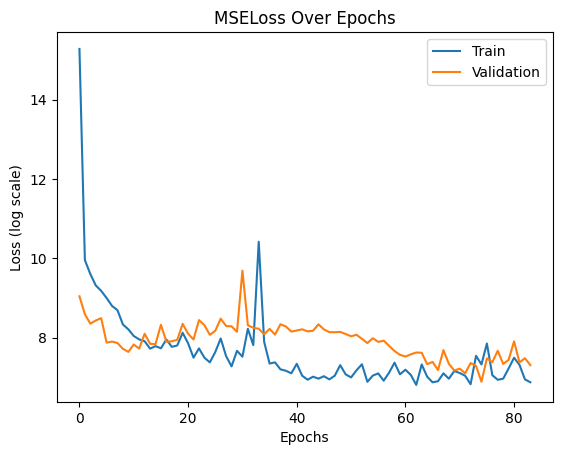

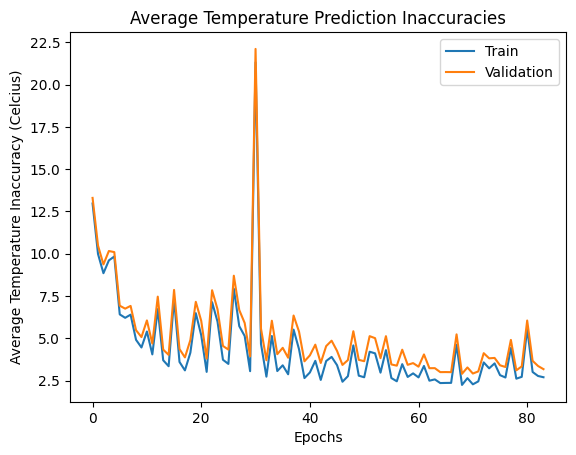

In [24]:
#Optimal params: 'lr': 0.004799821565505988, 'batchSize': 26, 'epochs': 84, 'hidden_size': 45
# if 'study' in locals():
#     print(study.best_params)
#     study = study.best_params
# else:
study={'lr': 0.004799821565505988, 'batchSize': 26, 'epochs': 84, 'hidden_size': 45}
model = FlatWeatherMLP(hidden_size=study['hidden_size'])
train_model(model, train_data, val_data, lr=study['lr'], batchSize=study['batchSize'], epochs=study['epochs'], plot=True)
accuracy(model, data['test'])

This linear model achieves an accuracy of an average of 3.05 degrees from the true results when predicting the next day's temperature using the current day's weather data